In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
import nilearn
from tree_features import connectome_average, matrix_fusion, tree_connectivity, tree_modules, level_dictionary, level_from_tree
from tree_features import T_from_level, adj_matrices_from_level, brain_maps_network_measure, threshold_based_similarity_external, density_threshold
from tree_features import tree_dictionary, get_module_vol, cross_modularity, add_gamma_to_lvl_dict, threshold_based_similarity, modularity, network_from_level
from tree_features import measure_betweenness, measure_strength, measure_clustering_coef, measure_pathlength, get_atlas_rois_from_mask
from io_functions import load_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
import networkx as nx

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/antoniojm/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [6]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/schaefer"
sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))

In [7]:
fcm, scm = connectome_average(fc_group, sc_group)
print(fcm.shape)
print(scm.shape)

(1000, 1000)
(1000, 1000)


In [10]:
density = np.where(scm.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm.flatten()))
fcm_thr = density_threshold(fcm, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
zero_rows_fc

array([289, 290, 293, 830])

In [16]:
#remove the element zero_rows from fcm and scm
fcm_thr_nonzero = np.delete(fcm_thr, zero_rows_fc, axis=0)
fcm_thr_nonzero = np.delete(fcm_thr_nonzero, zero_rows_fc, axis=1)
scm_nonzero = np.delete(scm, zero_rows_fc, axis=0)
scm_nonzero = np.delete(scm_nonzero, zero_rows_fc, axis=1)
fcm_bin = np.where(fcm_thr_nonzero > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 
print(fcm_bin.shape)
print(scm_bin.shape)

(996, 996)
(996, 996)


Text(0.5, 1.0, 'Structural connectivity matrix')

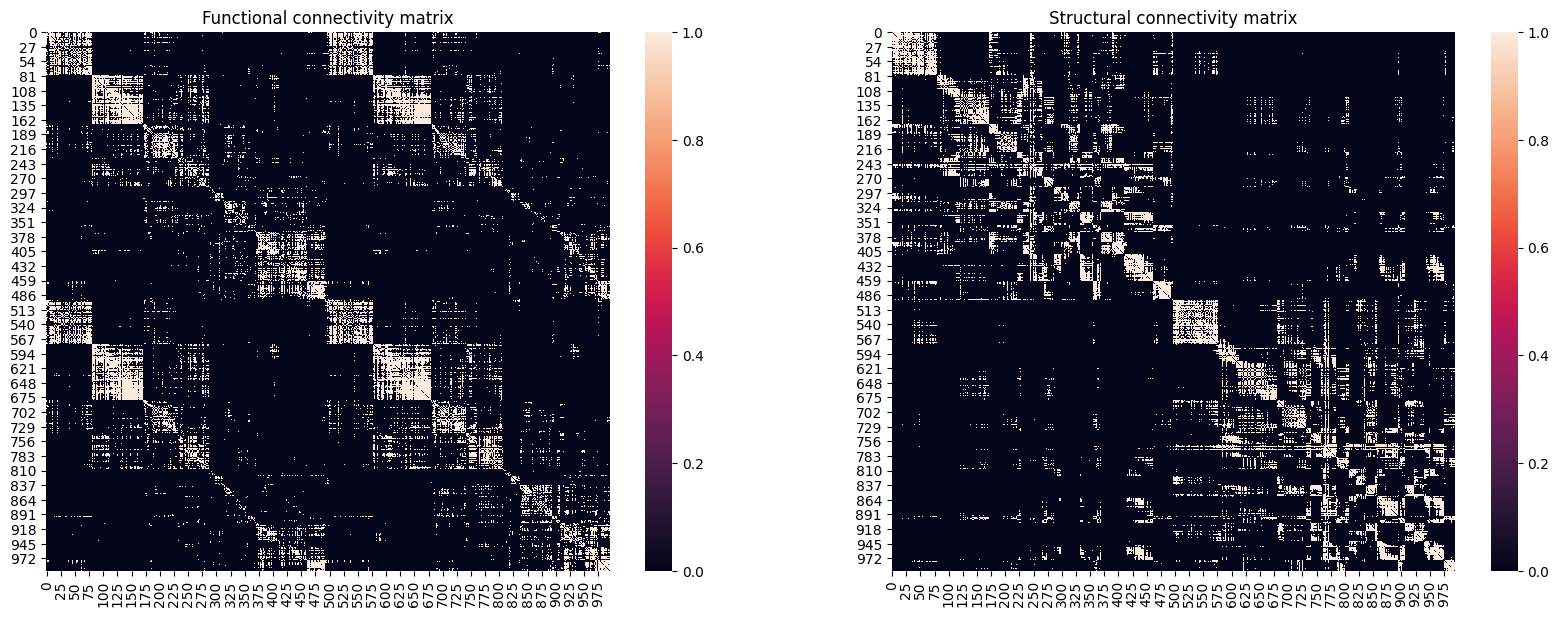

In [17]:
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_bin, ax=ax[0])
ax[0].set_title("Functional connectivity matrix")
sns.heatmap(scm_bin, ax=ax[1])
ax[1].set_title("Structural connectivity matrix")

In [71]:
def module_segregation(matrix, rois):
    m = sum(matrix.flatten())
    mc = matrix[rois][:, rois]
    return sum(mc.flatten()) / m

def module_integration(matrix, rois):
    m = sum(matrix.flatten())
    ext_rois = np.setdiff1d(np.array([i for i in range(len(matrix))]), rois)
    mc = matrix[rois][:, rois]
    ec = matrix[rois][:,ext_rois]
    integration = np.power((2*sum(mc.flatten()) + sum(ec.flatten())) / (2*m), 2)
    return integration

In [69]:
roi_labels = pd.read_csv(os.path.join(project_path, "labels_desc.csv"))
roi_labels = roi_labels.drop(zero_rows_fc)
roi_labels = roi_labels.reset_index(drop=True)
roi_labels["ROI Label"] = roi_labels.index + 1


(0.0, 0.09)

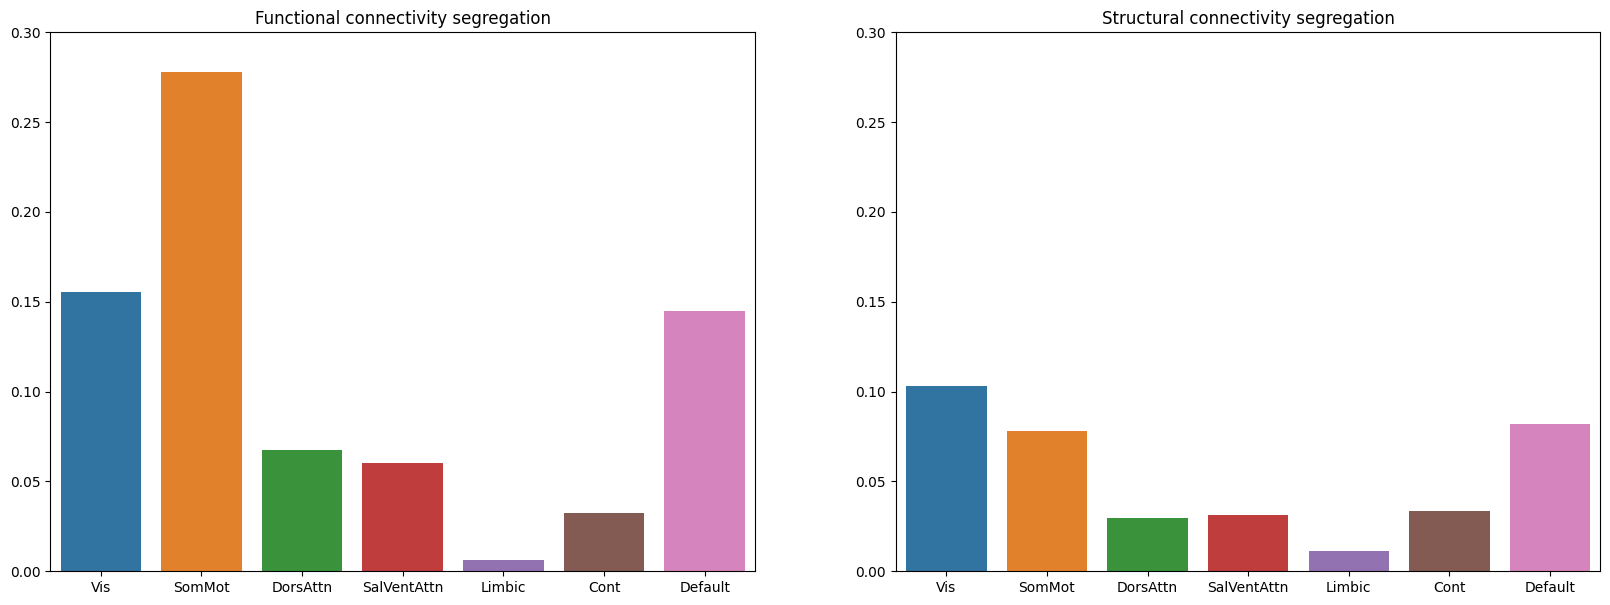

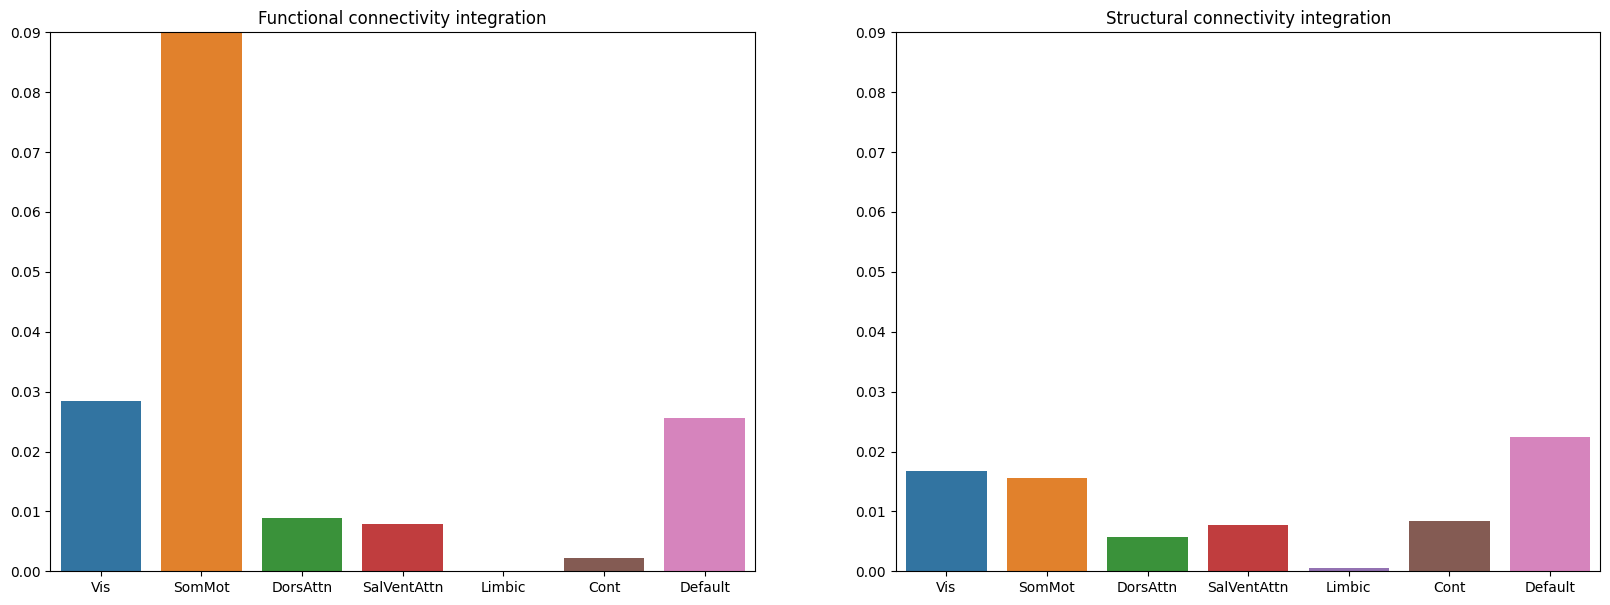

In [76]:

label_patterns = ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]

segregations_fc = []
integrations_fc = []
energies_fc = []
segregations_sc = []
integrations_sc = []
energies_sc = []

for pattern in label_patterns:
    rois = roi_labels[roi_labels["ROI Name"].str.contains(pattern)]["ROI Label"].values - 1
    segregations_fc.append(module_segregation(fcm_bin, rois))
    integrations_fc.append(module_integration(fcm_bin, rois))
    energies_fc.append(module_integration(fcm_bin, rois)-module_segregation(fcm_bin, rois))
    segregations_sc.append(module_segregation(scm_bin, rois))
    integrations_sc.append(module_integration(scm_bin, rois))
    energies_sc.append(module_integration(scm_bin, rois)-module_segregation(scm_bin, rois))

#plot segregations_fc with discrete values in seaborn
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(x=label_patterns, y=segregations_fc, ax=ax[0])
ax[0].set_title("Functional connectivity segregation")
ax[0].set_ylim(0, 0.3)
sns.barplot(x=label_patterns, y=segregations_sc, ax=ax[1])
ax[1].set_title("Structural connectivity segregation")
ax[1].set_ylim(0, 0.3)

#plot integrations_fc with discrete values in seaborn
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(x=label_patterns, y=integrations_fc, ax=ax[0])
ax[0].set_title("Functional connectivity integration")
ax[0].set_ylim(0, 0.09)
sns.barplot(x=label_patterns, y=integrations_sc, ax=ax[1])
ax[1].set_title("Structural connectivity integration")
ax[1].set_ylim(0, 0.09)

# #plot energies_fc with discrete values in seaborn
# plot, ax = plt.subplots(1, 2, figsize=(20, 7))
# sns.barplot(x=label_patterns, y=energies_fc, ax=ax[0])
# ax[0].set_title("Functional connectivity energy")
# sns.barplot(x=label_patterns, y=energies_sc, ax=ax[1])
# ax[1].set_title("Structural connectivity energy")